# Proyek Klasifikasi Gambar: Intel Image Classification
- **Nama:** Lina Fadilah
- **Email:** linahardiyana@gmail.com
- **ID Dicoding:** linafadilah

## Import Semua Packages/Library yang Digunakan

In [2]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 58.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-d

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import itertools
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Add, Flatten, MaxPooling2D, Dense, BatchNormalization, Input, Flatten, Dropout, GlobalMaxPooling2D, Lambda
from tensorflow.keras.models import Model
import tensorflowjs as tfjs
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from google.colab import files
import ipywidgets as widgets
from PIL import Image
import io
import os
import time
from IPython.display import FileLink, FileLinks
from google.colab import drive
import shutil
import zipfile
import filecmp
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
import cv2
import random
from tensorflow.keras import layers, models
from keras.layers import TFSMLayer


In [4]:
drive.mount('/content/drive')  # Now you can use the drive object after importing it

Mounted at /content/drive


In [5]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
# Memindahkan file ke folder di Google Drive
uploaded_filename = list(uploaded.keys())[0]  # Mengambil nama file yang diunggah

# Path di Google Drive tempat menyimpan file
drive_path = '/content/drive/MyDrive/.kaggle/'

# Pastikan direktori tujuan ada
os.makedirs(drive_path, exist_ok=True)  # Membuat direktori jika belum ada

# Pindahkan file ke Google Drive
shutil.move(uploaded_filename, drive_path + uploaded_filename)

print(f"File {uploaded_filename} berhasil disimpan di Google Drive.")

File kaggle.json berhasil disimpan di Google Drive.


In [7]:
# Mengatur path ke folder .kaggle di Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = r"/content/drive/MyDrive/.kaggle"

# Cek apakah kaggle.json ada di folder .kaggle
!ls /content/drive/MyDrive/.kaggle


'kaggle (1).json'   kaggle.json


## Data Preparation

### Data Loading

In [ ]:
# Unduh dataset dari Kaggle
!kaggle datasets download -d puneet6060/intel-image-classification -p /content/drive/MyDrive/intel-image-classification


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 97% 337M/346M [00:04<00:00, 54.9MB/s]
100% 346M/346M [00:04<00:00, 76.5MB/s]


In [ ]:
zip_path = '/content/drive/MyDrive/intel-image-classification/intel-image-classification.zip'
extract_to = '/content/drive/MyDrive/intel-image-classification'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")

Extraction complete.


In [10]:
# Direktori baru untuk dataset gabungan
combined_dir = "/content/drive/MyDrive/intel-image-classification/dataset"

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Preprocessing

In [ ]:
# Direktori awal untuk train dan test
train_dir = "/content/drive/MyDrive/intel-image-classification/seg_train/seg_train"
test_dir = "/content/drive/MyDrive/bird-classification/seg_test/seg_test"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

def move_and_check(src_dir, dest_dir):
    for root, dirs, files in os.walk(src_dir):
        for file in files:
            src_file = os.path.join(root, file)
            rel_path = os.path.relpath(src_file, src_dir)
            dest_file = os.path.join(dest_dir, rel_path)
            dest_file_dir = os.path.dirname(dest_file)

            if not os.path.exists(dest_file_dir):
                os.makedirs(dest_file_dir)

            if os.path.exists(dest_file):
                if filecmp.cmp(src_file, dest_file, shallow=False):
                    os.remove(src_file)  # Hapus file sumber jika kontennya sama
                else:
                    base, ext = os.path.splitext(file)
                    new_file = f"{base}_new{ext}"
                    dest_file = os.path.join(dest_file_dir, new_file)
                    shutil.move(src_file, dest_file)
            else:
                shutil.move(src_file, dest_file)

# Pindahkan file dan folder dari train
move_and_check(train_dir, combined_dir)

# Pindahkan file dan folder dari test
move_and_check(test_dir, combined_dir)

In [ ]:
# Hapus Zip
!rm -rf '/content/drive/MyDrive/intel-image-classification/intel-image-classification.zip'

In [12]:
# Direktori tempat gambar disimpan
directory_path = Path(combined_dir)

# Mendapatkan semua jalur file gambar dengan ekstensi .png dan .jpg/.jpeg
filepaths_png = list(directory_path.glob(r'**/*.png'))
filepaths_jpeg = list(directory_path.glob(r'**/*.jpg')) + list(directory_path.glob(r'**/*.jpeg'))
filepaths = filepaths_png + filepaths_jpeg

# Mendapatkan label dari nama folder
labels = [os.path.split(os.path.split(x)[0])[1] for x in filepaths]

# Mengubah jalur file menjadi DataFrame dan mengonversi ke tipe string
filepaths = pd.DataFrame(filepaths, columns=['Filepath']).astype(str)

# Mengubah label menjadi DataFrame
labels = pd.DataFrame(labels, columns=['Label'])

# Menggabungkan DataFrame filepaths dan labels
image_df = pd.concat([filepaths, labels], axis=1)

# Mengacak DataFrame dan mengatur ulang indeks
image_df = image_df.sample(frac=1).reset_index(drop=True)

# Menampilkan jumlah total gambar yang berhasil ditemukan
image_df = pd.concat([filepaths, labels], axis=1)  # Menggabungkan DataFrame filepaths dan labels
image_df = image_df.sample(frac=1).reset_index(drop=True) # Mengacak DataFrame dan mengatur ulang indeks
image_df.head(10) # Menampilkan 10 baris pertama dari DataFrame

,Filepath,Label
0,/content/drive/MyDrive/intel-image-classificat...,mountain
1,/content/drive/MyDrive/intel-image-classificat...,mountain
2,/content/drive/MyDrive/intel-image-classificat...,mountain
3,/content/drive/MyDrive/intel-image-classificat...,sea
4,/content/drive/MyDrive/intel-image-classificat...,sea
5,/content/drive/MyDrive/intel-image-classificat...,mountain
6,/content/drive/MyDrive/intel-image-classificat...,mountain
7,/content/drive/MyDrive/intel-image-classificat...,sea
8,/content/drive/MyDrive/intel-image-classificat...,mountain
9,/content/drive/MyDrive/intel-image-classificat...,glacier


In [13]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8096 entries, 0 to 8095
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  8096 non-null   object
 1   Label     8096 non-null   object
dtypes: object(2)
memory usage: 126.6+ KB


In [14]:
def display_sample_image_resolutions(directory, sample_size=10):
    images = []  # Membuat list kosong untuk menyimpan path gambar
    for root, _, files in os.walk(directory):  # Mengiterasi melalui directory secara rekursif
        for file in files:  # Mengiterasi melalui semua file dalam direktori
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):  # Mengecek apakah file memiliki ekstensi gambar yang valid
                images.append(os.path.join(root, file))  # Menambahkan path file ke list images

    if len(images) > sample_size:
        sample_images = random.sample(images, sample_size)  # Mengambil sejumlah gambar secara acak sesuai dengan sample_size dari list images
    else:
        sample_images = images  # Jika jumlah gambar lebih sedikit dari sample_size, gunakan semua gambar

    for img_path in sample_images:  # Mengiterasi melalui sample_images
        try:
            with Image.open(img_path) as img:  # Mencoba membuka gambar menggunakan PIL
                width, height = img.size  # Mendapatkan ukuran (lebar dan tinggi) gambar
                print(f"Image: {img_path}, Resolution: {width}x{height}")  # Mencetak path gambar dan resolusinya
        except (IOError, SyntaxError) as e:  # Menangkap kesalahan jika ada masalah membuka atau membaca gambar
            print(f"Error processing file {img_path}: {e}")  # Mencetak pesan error

# Panggil fungsi
display_sample_image_resolutions(directory_path, sample_size=20)


Image: /content/drive/MyDrive/intel-image-classification/dataset/sea/11974.jpg, Resolution: 150x150
Image: /content/drive/MyDrive/intel-image-classification/dataset/street/1556.jpg, Resolution: 150x150
Image: /content/drive/MyDrive/intel-image-classification/dataset/sea/4669.jpg, Resolution: 150x150
Image: /content/drive/MyDrive/intel-image-classification/dataset/sea/15456.jpg, Resolution: 150x150
Image: /content/drive/MyDrive/intel-image-classification/dataset/mountain/2672.jpg, Resolution: 150x150
Image: /content/drive/MyDrive/intel-image-classification/dataset/sea/17997.jpg, Resolution: 150x150
Image: /content/drive/MyDrive/intel-image-classification/dataset/glacier/4317.jpg, Resolution: 150x150
Image: /content/drive/MyDrive/intel-image-classification/dataset/sea/2529.jpg, Resolution: 150x150
Image: /content/drive/MyDrive/intel-image-classification/dataset/sea/3467.jpg, Resolution: 150x150
Image: /content/drive/MyDrive/intel-image-classification/dataset/mountain/3190.jpg, Resolution

In [15]:
# Ekstensi gambar yang ingin dihitung
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']

# Fungsi untuk memeriksa apakah suatu file adalah gambar
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in image_extensions)

# Menghitung jumlah file gambar dalam direktori
def count_image_files(directory):
    count = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                count += 1
    return count

# Menghitung jumlah file gambar dalam direktori
n_image_files = count_image_files(directory_path)
print(f"Jumlah file gambar: {n_image_files}")

Jumlah file gambar: 8096


In [16]:
# Fungsi untuk memeriksa apakah ada file gambar di dalam folder
def has_image_files(folder_path):
    for file in os.listdir(folder_path):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            return True
    return False

# Menghitung jumlah folder yang berisi gambar
def count_folders_with_images(directory):
    count = 0
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path) and has_image_files(folder_path):
            count += 1
    return count

# Menghitung jumlah folder yang berisi gambar
n_folders_with_images = count_folders_with_images(directory_path)
print(f"Jumlah folder yang berisi gambar: {n_folders_with_images}")

Jumlah folder yang berisi gambar: 4


In [17]:
dataset_img = {} # Membuat dictionary yang menyimpan nama-nama file gambar untuk setiap kelas dalam data

for class_name in os.listdir(directory_path): # Mengiterasi setiap direktori (kelas) dalam direktori utama
    dataset_img[class_name] = os.listdir(os.path.join(directory_path, class_name)) # Menyimpan daftar file gambar untuk setiap kelas

# Pilih secara acak 3 kelas dari dataset
random_classes = np.random.choice(list(dataset_img.keys()), 3, replace=False) # Memilih 3 kelas secara acak dari keys dataset_img tanpa penggantian

# Menampilkan secara acak 4 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(random_classes), 4, figsize=(15, 15)) # Membuat subplot dengan jumlah baris sesuai dengan jumlah kelas acak dan 4 kolom, ukuran figur 15x15

for i, class_name in enumerate(random_classes): # Mengiterasi kelas acak
    images = np.random.choice(dataset_img[class_name], 4, replace=False) # Memilih 4 gambar secara acak dari daftar gambar dalam kelas tanpa penggantian

    for j, image_name in enumerate(images): # Mengiterasi gambar acak dalam kelas
        img_path = os.path.join(directory_path, class_name, image_name) # Mendapatkan path lengkap dari gambar
        img = Image.open(img_path) # Membuka gambar menggunakan PIL
        axs[i, j].imshow(img) # Menampilkan gambar pada subplot yang sesuai
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[]) # Mengatur label sumbu x dengan nama kelas dan menghapus ticks sumbu x dan y
        img.close()  # Tutup gambar setelah digunakan untuk menghemat memori

fig.tight_layout() # Mengatur layout figur agar lebih rapi
plt.show() # Menampilkan figur

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-18-03604ae8f1ee>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot_data.set_xticklabels(plot_data.get_xticklabels(), rotation=45, horizontalalignment='right') # Mengatur label sumbu x dengan rotasi 45 derajat dan perataan kanan


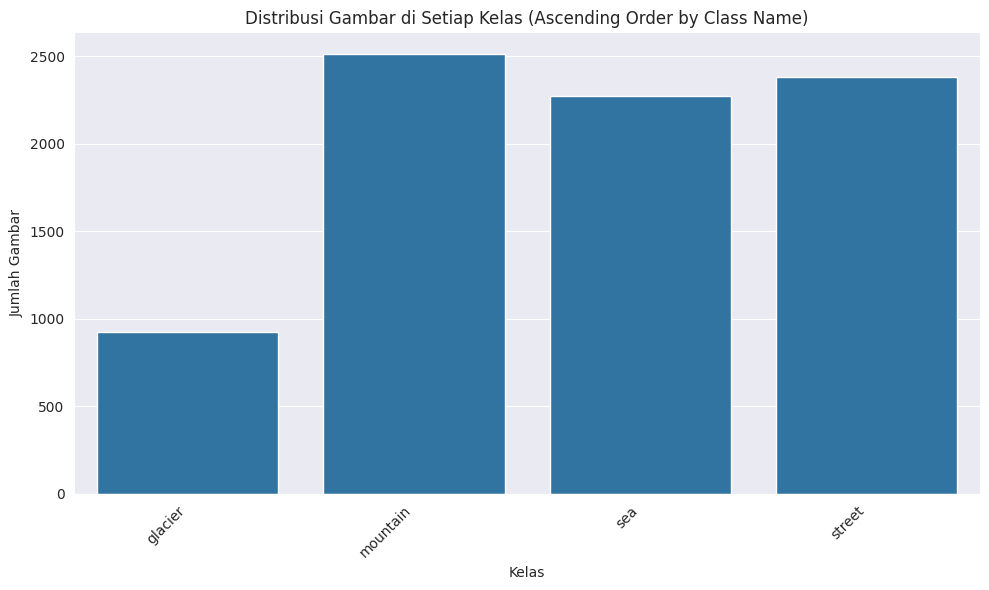

In [18]:
# Membuat list untuk menyimpan data setiap nama file, path lengkap, dan label dalam data
file_name = [] # List untuk menyimpan nama file gambar
labels = [] # List untuk menyimpan label (nama kelas) gambar
full_path = [] # List untuk menyimpan path lengkap gambar

# Mendapatkan nama file gambar, path lengkap, dan label satu per satu menggunakan os.walk
for path, subdirs, files in os.walk(directory_path): # Mengiterasi direktori secara rekursif
    for name in files: # Mengiterasi semua file dalam direktori saat ini
        full_path.append(os.path.join(path, name)) # Menambahkan path lengkap gambar ke list full_path
        labels.append(path.split('/')[-1]) # Menambahkan nama kelas (label) ke list labels
        file_name.append(name) # Menambahkan nama file ke list file_name

# Membuat dataframe untuk menyimpan data yang dikumpulkan
distribution_data = pd.DataFrame({ # Membuat dataframe dengan kolom path, file_name, dan labels
    "path": full_path,
    'file_name': file_name,
    "labels": labels
})

# Mengubah kolom 'labels' pada dataframe 'distribution_data' menjadi tipe data kategori
distribution_data['labels'] = distribution_data['labels'].astype('category') # Mengubah tipe data kolom 'labels' menjadi kategori

# Plotting distribusi jumlah gambar di setiap kelas
plt.figure(figsize=(10, 6)) # Mengatur ukuran figur
sns.set_style("darkgrid") # Mengatur gaya plot menjadi darkgrid
plot_data = sns.countplot(x='labels', data=distribution_data, order=distribution_data['labels'].cat.categories) # Membuat countplot jumlah gambar di setiap kelas
plot_data.set_xticklabels(plot_data.get_xticklabels(), rotation=45, horizontalalignment='right') # Mengatur label sumbu x dengan rotasi 45 derajat dan perataan kanan
plt.xlabel('Kelas') # Mengatur label sumbu x
plt.ylabel('Jumlah Gambar') # Mengatur label sumbu y
plt.title('Distribusi Gambar di Setiap Kelas (Ascending Order by Class Name)') # Mengatur judul plot
plt.tight_layout() # Mengatur layout agar lebih rapi
plt.show() # Menampilkan plot

### Split Dataset

In [19]:
# Membagi dataset menjadi training dan test set dengan stratifikasi
train_df, test_df = train_test_split(
    distribution_data, test_size=0.2, shuffle=True, random_state=1, stratify=distribution_data['labels'])

print(f"Jumlah kelas di train_df: {train_df['labels'].nunique()}")
print(f"Jumlah kelas di test_df: {test_df['labels'].nunique()}")


Jumlah kelas di train_df: 4
Jumlah kelas di test_df: 4


In [20]:
# Mengganti nama kolom agar sesuai dengan flow_from_dataframe
train_df = train_df.rename(columns={'path': 'Filepath', 'labels': 'Label'})
test_df = test_df.rename(columns={'path': 'Filepath', 'labels': 'Label'})


In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Mengubah nilai piksel menjadi rentang 0-1 untuk mempercepat pelatihan
    shear_range=0.2,           # Mengaplikasikan transformasi shear secara acak
    width_shift_range=0.2,     # Menggeser gambar secara horizontal secara acak
    height_shift_range=0.2,    # Menggeser gambar secara vertikal secara acak
    horizontal_flip=True
)

test_generator = ImageDataGenerator(
    rescale=1.0/255            # Mengubah nilai piksel pada data uji menjadi rentang 0-1
)

In [22]:
# Fungsi untuk memeriksa validitas jalur file
def is_valid_file(path):
    return os.path.exists(path) and os.path.isfile(path)

# Menghapus baris dengan jalur file tidak valid dari DataFrame
def remove_invalid_filepaths(df, filepath_col):
    valid_df = df[df[filepath_col].apply(is_valid_file)].copy()
    return valid_df

# Memperbaiki DataFrame train_df, validation_df, dan test_df
train_df = remove_invalid_filepaths(train_df, 'Filepath')
test_df = remove_invalid_filepaths(test_df, 'Filepath')

print(f"Jumlah data train setelah validasi: {len(train_df)}")
print(f"Jumlah data test setelah validasi: {len(test_df)}")

Jumlah data train setelah validasi: 6476
Jumlah data test setelah validasi: 1620


In [23]:
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',           # Kolom yang berisi jalur file gambar
    y_col='Label',              # Kolom yang berisi label kelas
    target_size=(150, 150),     # Ukuran gambar setelah dimuat
    color_mode='rgb',           # Mode warna gambar (RGB)
    class_mode='categorical',   # Mode kelas output untuk klasifikasi multi-kelas
    batch_size=32,              # Jumlah gambar yang diproses per batch
    shuffle=True,               # Mengacak data setiap epoch
    seed=42,                    # Seed untuk hasil acak yang konsisten
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',           # Kolom yang berisi jalur file gambar
    y_col='Label',              # Kolom yang berisi label kelas
    target_size=(150, 150),     # Ukuran gambar setelah dimuat
    color_mode='rgb',           # Mode warna gambar (RGB)
    class_mode='categorical',   # Mode kelas output untuk klasifikasi multi-kelas
    batch_size=32,              # Jumlah gambar yang diproses per batch
    shuffle=False               # Tidak melakukan pengacakan pada data uji
)


Found 6476 validated image filenames belonging to 4 classes.
Found 1620 validated image filenames belonging to 4 classes.


In [24]:
num_classes = len(train_images.class_indices)
print(num_classes)

4


## Modelling

In [25]:
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Using CPU")

Using CPU


In [26]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [27]:
# Inisialisasi model Sequential
model = Sequential()

# Tambahkan layer konvolusi pertama
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

# Tambahkan layer konvolusi kedua
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Tambahkan layer konvolusi ketiga
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Tambahkan layer konvolusi keempat
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten output dari layer sebelumnya menjadi vektor
model.add(Flatten())

# Tambahkan fully connected layer pertama
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout untuk menghindari overfitting

# Tambahkan output layer dengan fungsi aktivasi softmax untuk klasifikasi multikelas
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# Compile model dengan optimizer Adam dan loss function categorical_crossentropy
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [29]:
# Tampilkan ringkasan model untuk melihat jumlah parameter dan struktur lapisan
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,454,660 (13.18 MB)

 Trainable params: 3,454,660 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Define callbacks
callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, monitor='val_loss')
]

In [32]:
# Melatih model
%time
start_time = time.time()

# Fit the model with callbacks
history = model.fit(
    train_images,
    epochs=30,
    batch_size=32,
    validation_data=test_images,
    callbacks=callbacks
)

execution_time = time.time() - start_time
print(f"Execution time: {execution_time:.2f} seconds")

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


203/203 ━━━━━━━━━━━━━━━━━━━━ 2292s 11s/step - accuracy: 0.5140 - loss: 1.0596 - val_accuracy: 0.7068 - val_loss: 0.7229 - learning_rate: 0.0010
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - accuracy: 0.6565 - loss: 0.7876 - val_accuracy: 0.7463 - val_loss: 0.5984 - learning_rate: 0.0010
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.7369 - loss: 0.6776 - val_accuracy: 0.6481 - val_loss: 0.7961 - learning_rate: 0.0010
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.7372 - loss: 0.6516 - val_accuracy: 0.7790 - val_loss: 0.5553 - learning_rate: 0.0010
Epoch 5/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.7979 - loss: 0.5586 - val_accuracy: 0.8500 - val_loss: 0.4121 - learning_rate: 0.0010
Epoch 6/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.8132 - loss: 0.5008 - val_accuracy: 0.8599 - val_loss: 0.3815 - learning_rate: 0.0010
Epoch 7/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.8307 - loss: 0.4595 - va

## Evaluasi dan Visualisasi

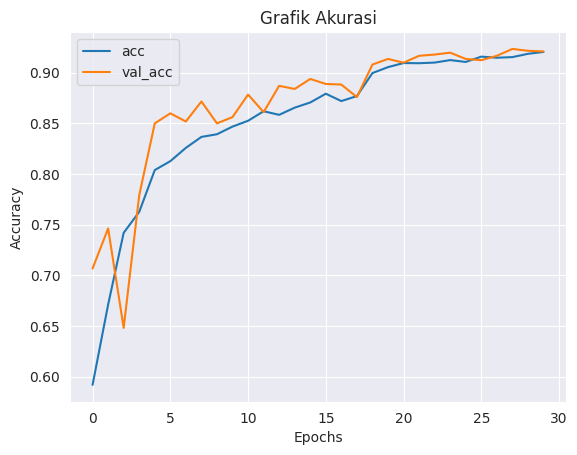

In [33]:

plt.plot(history.history['accuracy'], label='acc')  # Menggambar plot garis untuk akurasi pada setiap epoch dari riwayat pelatihan
plt.plot(history.history['val_accuracy'], label='val_acc')  # Menggambar plot garis untuk val_accuracy (akurasi validasi) pada setiap epoch dari riwayat pelatihan
plt.title('Grafik Akurasi')  # Menambahkan judul pada grafik Akurasi
plt.xlabel('Epochs')  # Menambahkan label pada sumbu X
plt.ylabel('Accuracy')  # Menambahkan label pada sumbu Y
plt.legend()  # Menampilkan legenda plot untuk membedakan antara acc dan val_acc
plt.grid(True)  # Menambahkan grid pada grafik (opsional)
plt.show()  # Menampilkan grafik

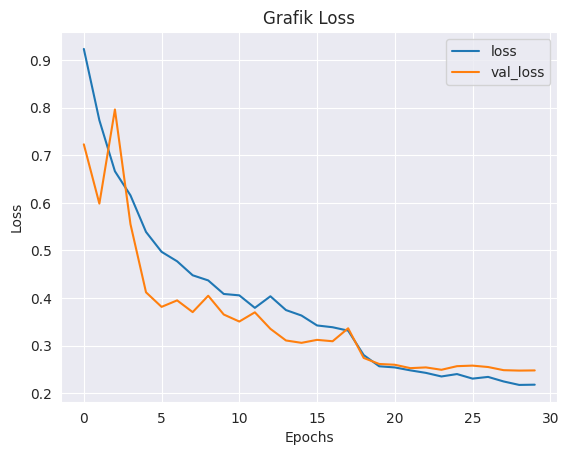

In [34]:
plt.plot(history.history['loss'], label='loss')  # Menggambar plot garis untuk loss pada setiap epoch dari riwayat pelatihan
plt.plot(history.history['val_loss'], label='val_loss')  # Menggambar plot garis untuk val_loss (kerugian validasi) pada setiap epoch dari riwayat pelatihan
plt.title('Grafik Loss')  # Menambahkan judul pada grafik Loss
plt.xlabel('Epochs')  # Menambahkan label pada sumbu X
plt.ylabel('Loss')  # Menambahkan label pada sumbu Y
plt.legend()  # Menampilkan legenda plot untuk membedakan antara loss dan val_loss
plt.grid(True)  # Menambahkan grid pada grafik (opsional)
plt.show()  # Menampilkan grafik

## Konversi Model

51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 578ms/step
Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

     glacier       0.75      0.76      0.76       186
    mountain       0.92      0.89      0.91       503
         sea       0.93      0.95      0.94       455
      street       0.98      0.99      0.98       476

    accuracy                           0.92      1620
   macro avg       0.90      0.90      0.90      1620
weighted avg       0.92      0.92      0.92      1620



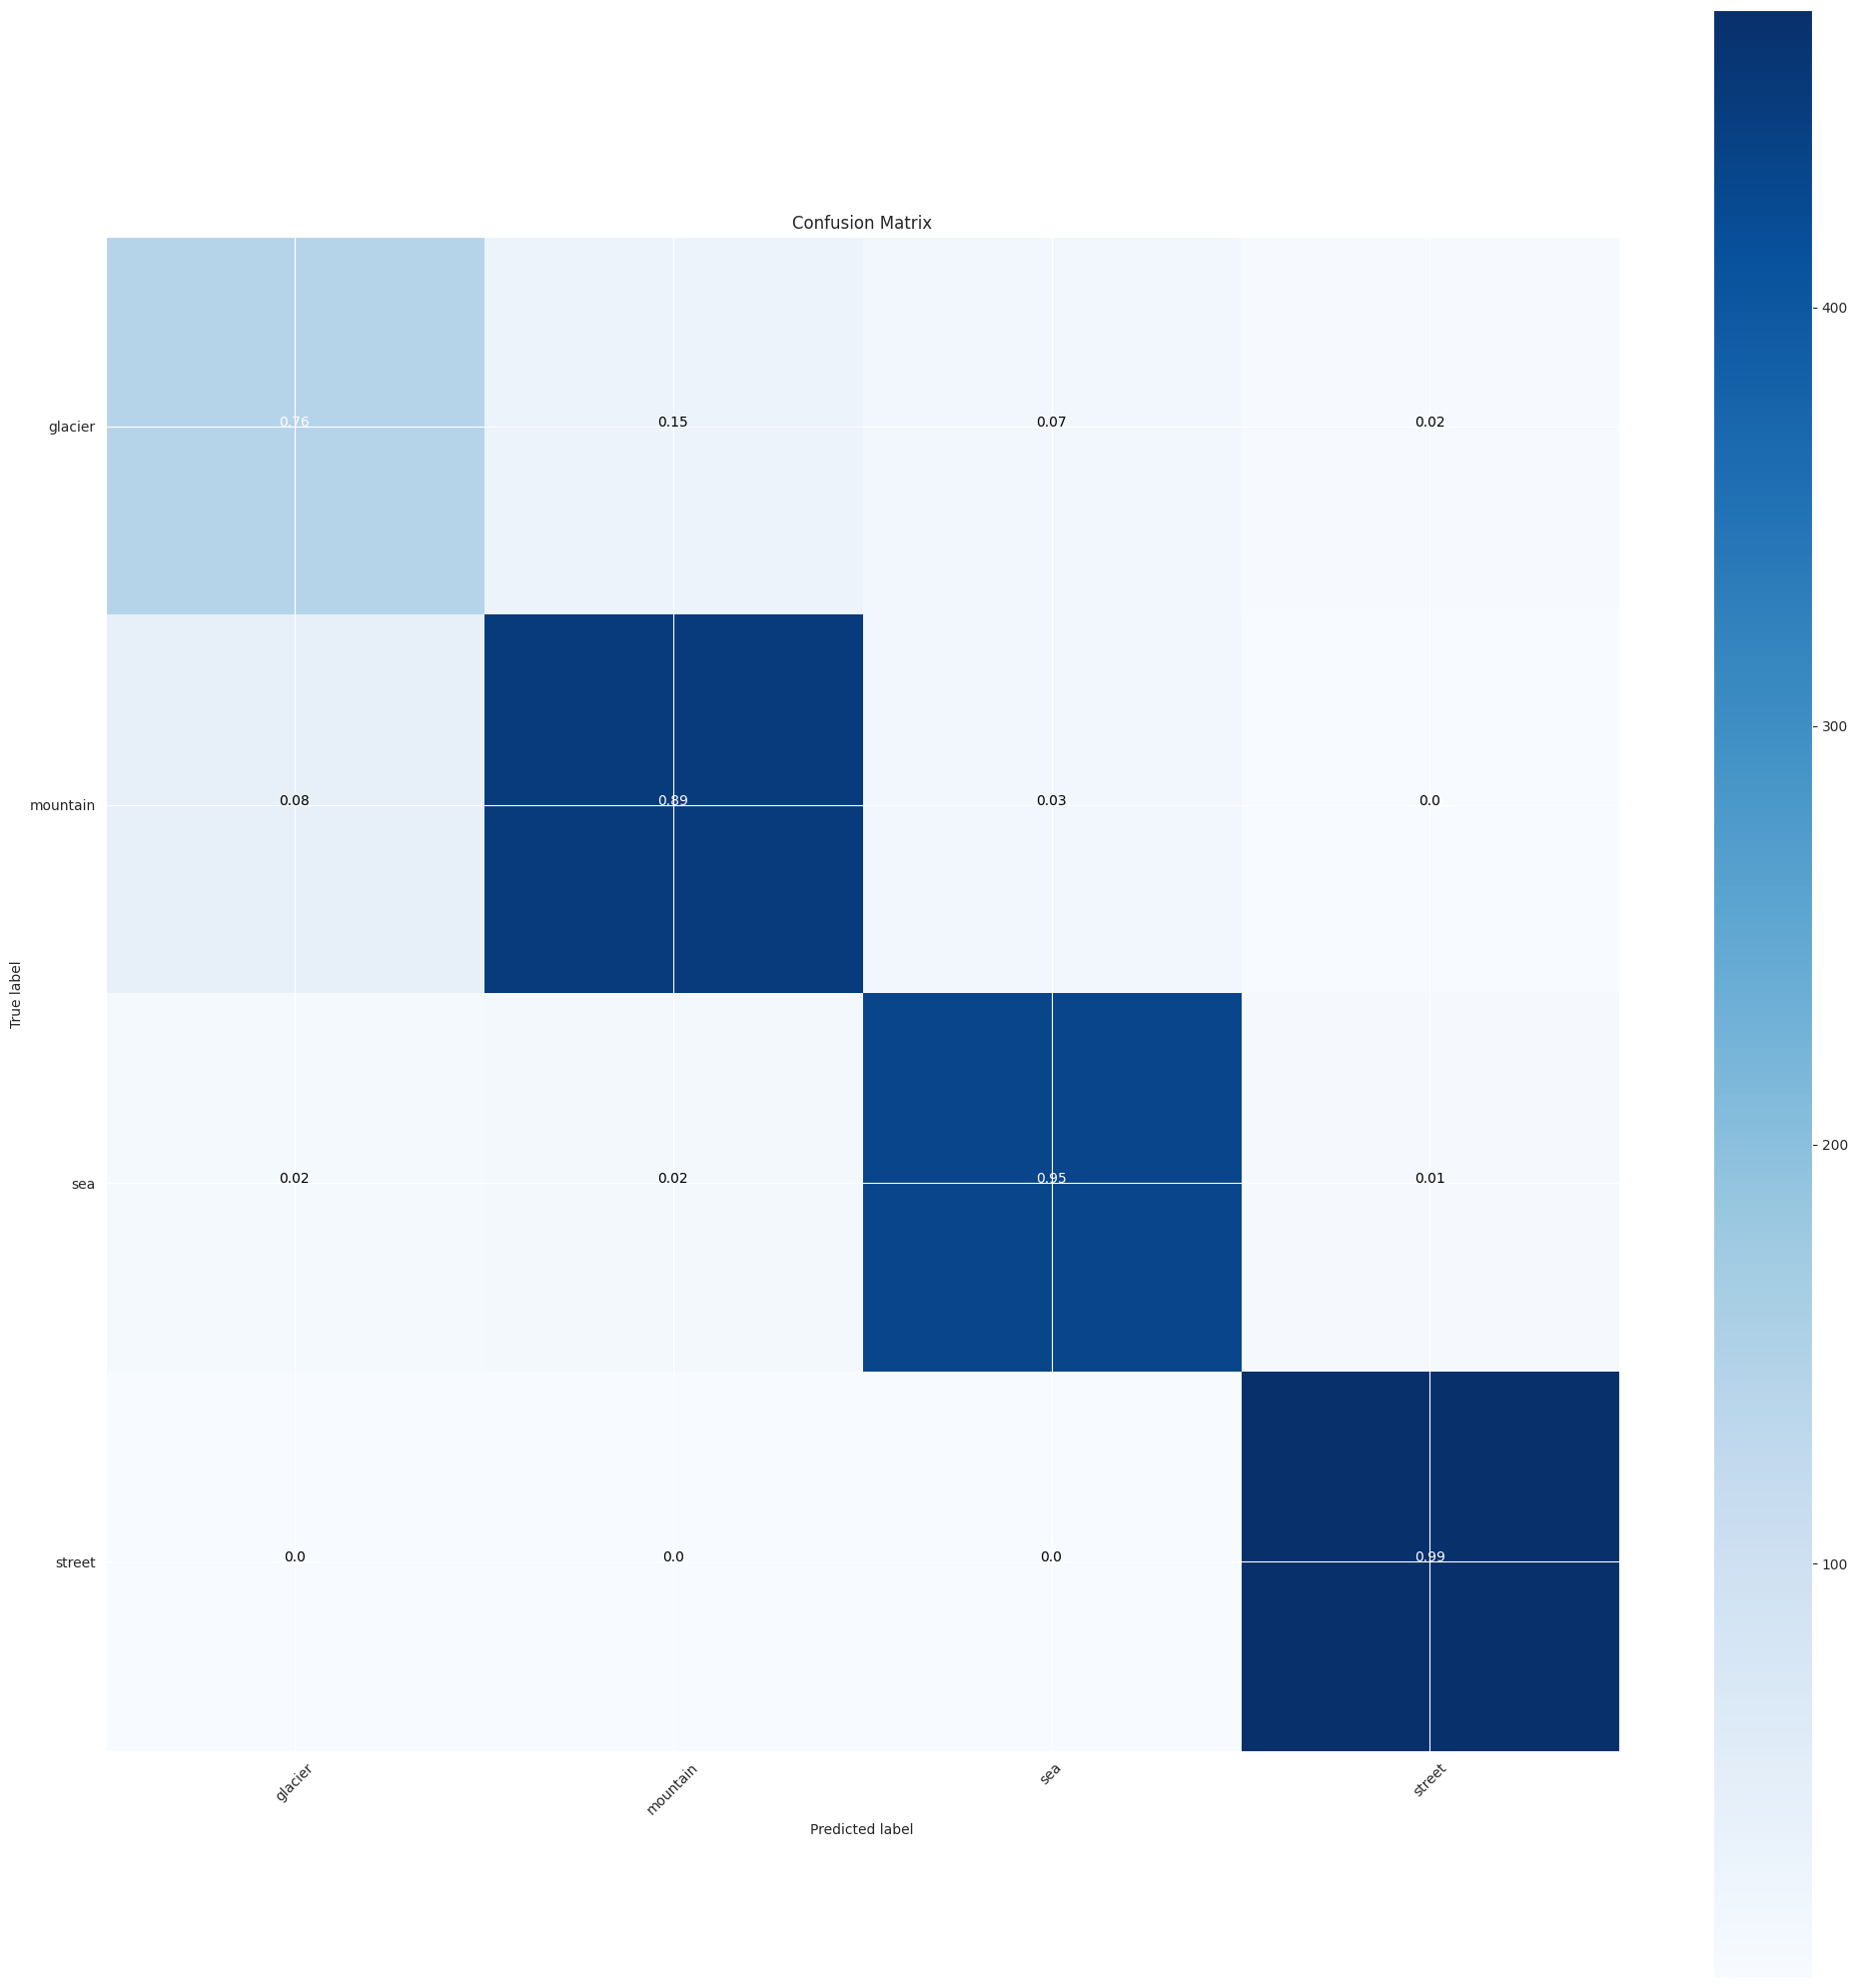

In [35]:
# Fungsi untuk memplot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap='Blues'):
    plt.figure(figsize=(20, 20))  # Mengatur ukuran gambar plot

    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # Menampilkan confusion matrix dengan cmap yang dipilih
    plt.title(title)  # Memberi judul pada plot
    plt.colorbar()  # Menambahkan color bar pada plot

    tick_marks = np.arange(len(classes))  # Mengatur tanda pada sumbu x dan y sesuai dengan jumlah kelas
    plt.xticks(tick_marks, classes, rotation=45)  # Mengatur label pada sumbu x dengan rotasi 45 derajat
    plt.yticks(tick_marks, classes)  # Mengatur label pada sumbu y

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisasi confusion matrix
        cm = np.around(cm, decimals=2)  # Membulatkan nilai dalam confusion matrix hingga 2 desimal
        cm[np.isnan(cm)] = 0.0  # Mengganti nilai NaN dengan 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.  # Menentukan ambang batas untuk teks warna
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):  # Mengisi nilai dalam confusion matrix dengan warna teks sesuai ambang batas
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()  # Mengatur layout plot agar lebih rapat
    plt.ylabel('True label')  # Menambahkan label sumbu y
    plt.xlabel('Predicted label')  # Menambahkan label sumbu x
    plt.savefig('confusion_matrix.png')  # Menyimpan plot confusion matrix sebagai file gambar

# Mengambil nama kelas dari objek train_images
target_names = []
for key in train_images.class_indices:
    target_names.append(key)

# Membuat prediksi menggunakan model pada data test_images
Y_pred = model.predict(test_images)  # Menggunakan model untuk memprediksi data test_images
y_pred = np.argmax(Y_pred, axis=1)  # Mengambil indeks prediksi dengan probabilitas tertinggi

# Mencetak confusion matrix
print('Confusion Matrix')
cm = confusion_matrix(test_images.classes, y_pred)  # Menghitung confusion matrix
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')  # Memplot confusion matrix

# Mencetak classification report
print('Classification Report')
print(classification_report(test_images.classes, y_pred, target_names=target_names))  # Menghitung dan mencetak classification report


In [36]:
# Evaluasi model menggunakan data uji (test_images)
test_results = model.evaluate(test_images, verbose=0)  # Evaluasi model menggunakan data uji, dengan verbose=0 untuk tidak menampilkan detail ekstra

# Evaluasi model menggunakan data pelatihan (train_images)
train_results = model.evaluate(train_images, verbose=0)  # Evaluasi model menggunakan data pelatihan, dengan verbose=0 untuk tidak menampilkan detail ekstra

# Menampilkan hasil evaluasi
print("Train Loss: {:.5f}".format(train_results[0]))  # Menampilkan nilai Train Loss dengan 5 desimal
print("Train Accuracy: {:.2f}%".format(train_results[1] * 100))  # Menampilkan nilai Train Accuracy dalam persentase

print("Test Loss: {:.5f}".format(test_results[0]))  # Menampilkan nilai Test Loss dengan 5 desimal
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))  # Menampilkan nilai Test Accuracy dalam persentase


Train Loss: 0.21252
Train Accuracy: 92.22%
Test Loss: 0.24762
Test Accuracy: 92.16%


**Simpan** Model

In [37]:
saved_model_dir = '/content/drive/MyDrive/intel-image-classification/SavedModel'
model.export(saved_model_dir)

Saved artifact at '/content/drive/MyDrive/intel-image-classification/SavedModel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138318283541488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138318283542016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138318283547824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138318285261280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138318285036656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138318285038064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138318285043520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138318285045104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138318284870176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138318284871056: TensorSpec(shape=(), dt

In [38]:
# Direktori model SavedModel
saved_model_dir = '/content/drive/MyDrive/intel-image-classification/SavedModel'

# Buat konverter TFLite dari model SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Konversi model ke format TFLite
tflite_model = converter.convert()

# Simpan model dalam format TFLite
tflite_model_name = '/content/drive/MyDrive/intel-image-classification/tflite/model.tflite'
with open(tflite_model_name, 'wb') as f:
    f.write(tflite_model)

In [39]:
# Konversi model SavedModel ke format TFJS
saved_model_dir = '/content/drive/MyDrive/intel-image-classification/SavedModel'
tfjs_model_dir = '/content/drive/MyDrive/intel-image-classification/tfjs'

# Jalankan konversi
!tensorflowjs_converter --input_format=tf_saved_model \
                        --output_format=tfjs_graph_model \
                        "{saved_model_dir}" \
                        "{tfjs_model_dir}"

2024-08-14 20:25:42.402197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 20:25:42.472183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 20:25:42.472310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 20:25:45.267193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Inference (Optional)

In [40]:
# Menyiapkan model TFLite dan nama kelas (jalankan sekali saja)
def setup_model_and_classes():
    global interpreter, input_details, output_details, class_names
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Path ke model TFLite
    tflite_model_path = '/content/drive/MyDrive/intel-image-classification/tflite/model.tflite'

    # Muat model TFLite
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Dapatkan informasi input dan output tensor
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Menentukan nama kelas dari dataset
    dataset_dir = '/content/drive/MyDrive/intel-image-classification/dataset'
    class_names = sorted(os.listdir(dataset_dir))

    print("Model dan kelas telah disiapkan.")
    print("Input details:", input_details)
    print("Output details:", output_details)
    print("Class names:", class_names)

# Fungsi untuk memproses gambar dan mendapatkan prediksi
def predict_image():
    # Unggah file gambar
    from google.colab import files  # Import the files object here
    uploaded = files.upload()

    # Fungsi untuk memproses gambar
    def preprocess_image(image, target_size):
        image = image.resize(target_size)
        image = np.array(image)
        image = image.astype(np.float32)
        image = image / 255.0  # Normalisasi jika diperlukan
        return np.expand_dims(image, axis=0)  # Tambahkan batch dimension

    # Proses setiap file gambar yang diunggah
    for filename in uploaded.keys():
        print('Nama file yang diunggah: {}'.format(filename))

        # Baca gambar dari file yang diunggah
        image = Image.open(io.BytesIO(uploaded[filename]))

        # Tampilkan gambar yang diunggah
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis('off')  # Matikan sumbu
        plt.show()

        # Proses gambar
        target_size = tuple(input_details[0]['shape'][1:3])  # Ukuran target dari model
        input_data = preprocess_image(image, target_size)

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Jalankan inferensi
        interpreter.invoke()

        # Ambil hasil output
        output_data = interpreter.get_tensor(output_details[0]['index'])
        print("Output data:", output_data)

        # Ambil indeks kelas dengan probabilitas tertinggi
        predicted_class_index = np.argmax(output_data)
        predicted_class_name = class_names[predicted_class_index]

        print("Predicted class index:", predicted_class_index)
        print("Predicted class name:", predicted_class_name)

# Jalankan fungsi setup_model_and_classes sekali untuk menyiapkan model
setup_model_and_classes()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model dan kelas telah disiapkan.
Input details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([  1, 150, 150,   3], dtype=int32), 'shape_signature': array([ -1, 150, 150,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 25, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Class names: ['glacier', 'mountain', 'sea', 'street']


Saving Gunung_Kerinci_dari_Muaralabuh.jpg to Gunung_Kerinci_dari_Muaralabuh.jpg
Nama file yang diunggah: Gunung_Kerinci_dari_Muaralabuh.jpg


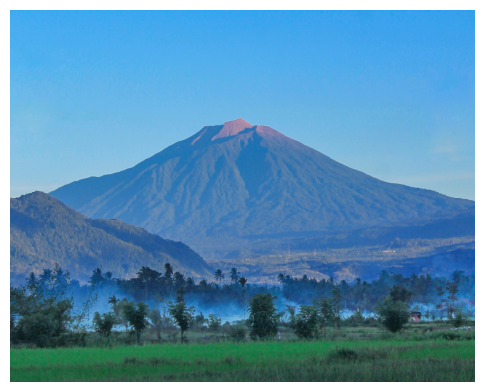

Output data: [[5.5353437e-04 9.9943358e-01 1.2829717e-05 2.1088813e-09]]
Predicted class index: 1
Predicted class name: mountain


In [41]:
predict_image()

Saving solo-kota.jpg to solo-kota.jpg
Nama file yang diunggah: solo-kota.jpg


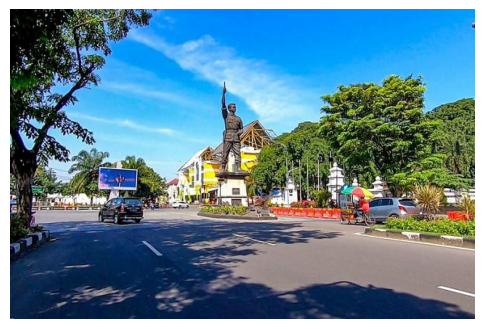

Output data: [[9.3290611e-05 1.8412588e-04 9.2142513e-03 9.9050832e-01]]
Predicted class index: 3
Predicted class name: street


In [42]:
predict_image()